In [2]:
import sys; sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt

from common.polymarket import fetch_event, filter_markets_by_volume, fetch_price_history

In [3]:
EVENT_ID = 903193  # 2024 US Presidential Election
# EVENT_ID = 12641  # TikTok banned in the US before May 2025?
EVENT_ID = 17088  # Ukraine war will end before July 2025?
EVENT_ID = 13551  # Trump end war in Ukraine first 90 days?
# EVENT_ID = 11322  # 

event = fetch_event(EVENT_ID)

print(f"Event: {event['title']}")
print(f"Total markets: {len(event['markets'])}")
print(f"Event period: {event['startDate']} → {event['endDate']}")

Event: Trump ends Ukraine war in first 90 days?
Total markets: 1
Event period: 2024-10-22T20:25:27.374418Z → 2025-04-20T12:00:00Z


In [4]:
filtered_markets = filter_markets_by_volume(event, threshold_pct=0.05)

print(f"Filtered to {len(filtered_markets)} markets (>5% volume):\n")
for m in filtered_markets:
    print(f"{m['question'][:60]}")
    print(f"  Volume: ${m['volume']:,.0f}\n")

Filtered to 1 markets (>5% volume):

Trump ends Ukraine war in first 90 days?
  Volume: $56,491,984



In [5]:
start_date = pd.to_datetime(event['startDate'], utc=True)
end_date = pd.to_datetime(event['endDate'], utc=True)

all_market_data = {}

for market in filtered_markets:
    data = fetch_price_history(market['token_id'], start_date, end_date)
    all_market_data[market['question']] = data
    print(f"{market['question'][:50]}: {len(data['times'])} points")

Trump ends Ukraine war in first 90 days?: 258658 points


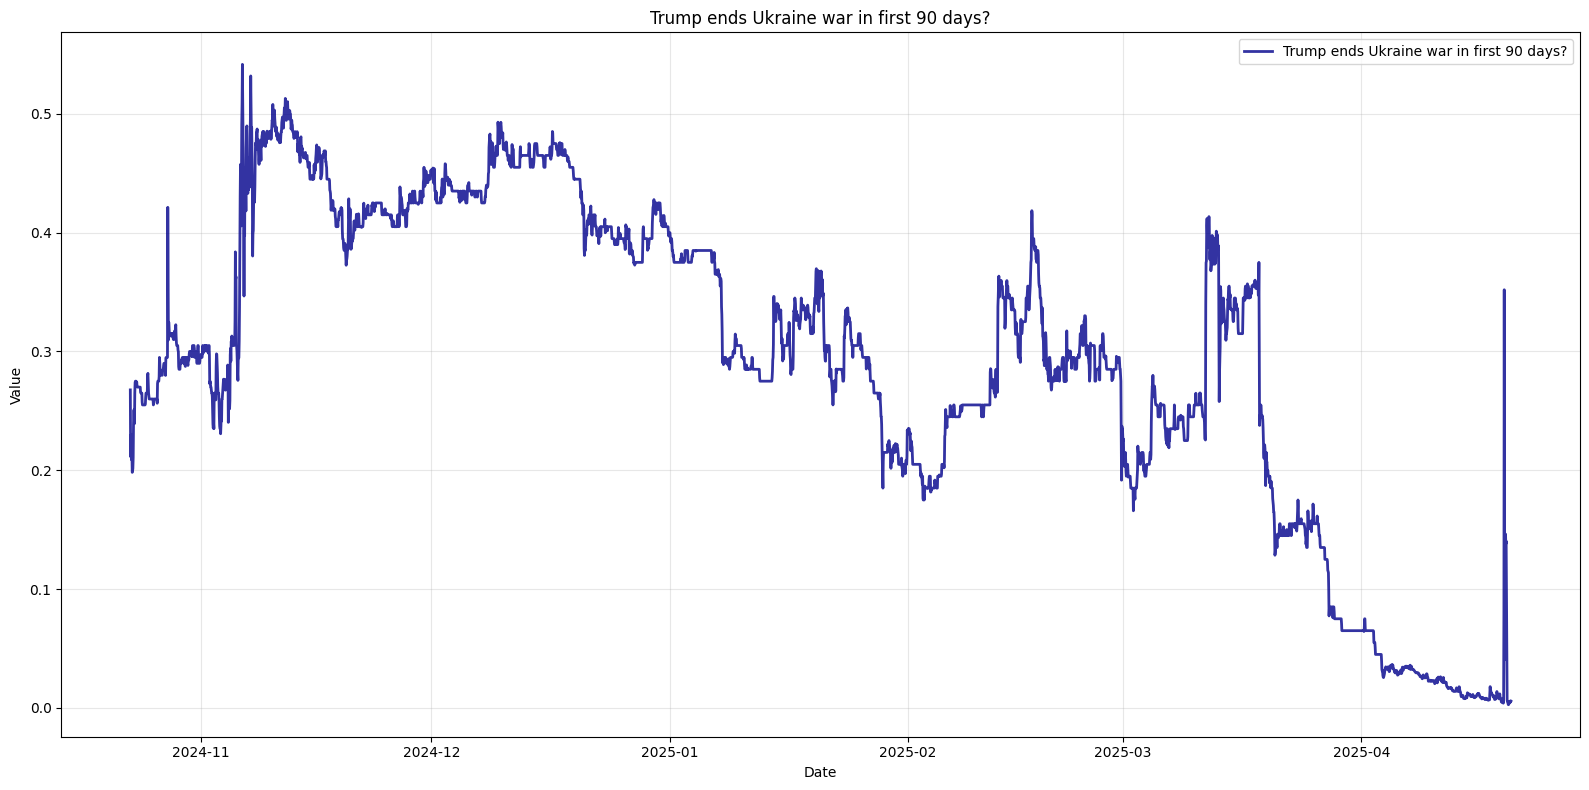

In [6]:
plt.figure(figsize=(16, 8))

colors = ['darkblue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

for idx, (question, data) in enumerate(all_market_data.items()):
    if len(data['times']) > 0:
        df_temp = pd.DataFrame({'time': data['times'], 'price': data['prices']})
        df_temp['hour'] = df_temp['time'].dt.floor('h')
        hourly = df_temp.groupby('hour')['price'].mean()

        plt.plot(hourly.index, hourly.values, linewidth=2, label=question, color=colors[idx % len(colors)], alpha=0.8)


plt.xlabel('Date')
plt.ylabel('Value')
plt.title(event['title'])
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
import json

data_to_save = {
    'event': {
        'id': EVENT_ID,
        'title': event['title'],
        'start_date': start_date.isoformat(),
        'end_date': end_date.isoformat(),
    },
    'markets': filtered_markets,
    'price_data': {
        question: {
            'times': [t.isoformat() for t in data['times']],
            'prices': data['prices']
        }
        for question, data in all_market_data.items()
    }
}

with open(f'../data/{event["slug"]}.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)

print(f"Saved to ../data/{event['slug']}.json")
print(f"  Event: {event['slug']}")
print(f"  Markets: {len(filtered_markets)}")
print(f"  Data points: {sum(len(d['times']) for d in all_market_data.values()):,}")

Saved to ../data/trump-wins-ends-ukraine-war-in-90-days.json
  Event: trump-wins-ends-ukraine-war-in-90-days
  Markets: 1
  Data points: 258,658
